# Project 2 report

*You can delete this cell, and add new cells to put your code and write your report.*

Question to answer: 
How has electricity consumption changed over the years 2015 to 2023? (If possible to find 2013 and 2014 datasets)?

How is the housing in each postcode and can any connection be observed between type of housing in a postcode and the consumption in that postcode? If the postcode had an increase in electricity consumption, can it be linked with the kind of housing it has developed over the years?

Data cleaning:
Georgia = 2022, 2023
Varsha = 2015, 2016
Yuning = 2017, 2018
Sizhe = 2019, 2020

Analyse the consumption in each outcode across the years.
Look at which outcode has the maximum change over the years and do a deeper analysis into factors which could have caused this.
Analyse a specific time period (2019-2022 Covid) for changes.

How has electricty consumption changed across the years, which council areas have a larger proportion of change. Were there different changes for Covid/Energy crisis periods? How does proportion of housing types in a data zone impact the electiricty consumption? Top5 council areas with large electricty changes, how do the housing proportions look? Rural and urban comparisons.


In [1]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# **Introduction**

Electricity consumption plays a crucial role in shaping a countries economic activity, environmental impact and long term sustainability. In the past decade, Scotland has initiated a rapid transition toward more renewable energy sources and has ambitious national energy targets. With a growing shrae of electricty coming from wind, hydro and other low carbon sources, Scotland offers a unique landscape for understanding how consumption patterns are evolving in a modern energy system.

This project examines electricity consumption in Scotland by exploring consumption trends over the past 10 years, regional differences and how accommodation types can alter the way electricty consumption has adjusted. By analysing these factors, the study aims to provide an insight into how Scotland's energy use is changing.

Understanding energy consumption is essential not only for managing resources efficiently but also for planning a resilient and environmentally responsible energy future. For this reason, Scotland's experience provides valuable lessons for other regions pursuing cleaner energy transitions.

# **Data Preparation**

The dataset for this project comes from one main source, data on electricity consumption for postcodes in 2023. Using the same data source we found replicas of this dataset for the years 2015 to 2023.
The datasets were loaded as CSV files using pandas. On initial investigation, it was found that the datasets contained all postcodes in the United Kingdom. The datasets were cleaned to remove English, Welsh and Northern Irish postcodes, leaving our datasets with Scottish postcodes solely.

We also prepared another dataset to us in our project, this is the Scottish housing data categorised by Data Zone. We cleaned this data to only contain the total percentages of 3 accommodation types, these being: Whole house or bungalows, Flats or apartments and Caravans or other mobile homes.


In [44]:

"""
Data Cleaning & Extraction Script.

This script handles the ETL (Extract, Transform, Load) process:
1.  Connects to UK Government servers to stream electricity data CSVs.
2.  Filters the data on-the-fly to retain only Scottish postcodes.
3.  Saves the processed, smaller datasets locally for analysis.

"""

#CONFIGURATION & CONSTANTS

# Determine the directory where this script is currently located
# This ensures output files are always saved relative to the script
SCRIPT_DIR = Path.cwd()
OUTPUT_DIR = SCRIPT_DIR / "clean_data"

# Set of Postcode Area prefixes belonging to Scotland
# Using a set for O(1) lookup speed during filtering
SCOT_AREAS = {
    "AB", "DD", "DG", "EH", "FK", "G", "HS", "IV", 
    "KA", "KW", "KY", "ML", "PA", "PH", "TD", "ZE"
}

# Regex pattern to extract the Area Prefix from a full postcode
AREA_RE = re.compile(r"^([A-Z]{1,2})")

# Direct download URLs for UK electricity consumption data (2015-2023)
DATA_URLS = {
    2023: "https://assets.publishing.service.gov.uk/media/6762f39cff2c870561bde826/Postcode_level_all_meters_electricity_2023.csv",
    2022: "https://assets.publishing.service.gov.uk/media/6762f29ecdb5e64b69e307db/Postcode_level_all_meters_electricity_2022.csv", 
    2021: "https://assets.publishing.service.gov.uk/media/6762f20f3229e84d9bbde81f/Postcode_level_all_meters_electricity_2021.csv",
    2020: "https://assets.publishing.service.gov.uk/media/6762f10dff2c870561bde823/Postcode_level_all_meters_electricity_2020.csv",
    2019: "https://assets.publishing.service.gov.uk/media/6762ec0c4e2d5e9c0bde9b2a/Postcode_level_all_meters_electricity_2019.csv",
    2018: "https://assets.publishing.service.gov.uk/media/6762eb504e2d5e9c0bde9b26/Postcode_level_all_meters_electricity_2018.csv",
    2017: "https://assets.publishing.service.gov.uk/media/6762ea7bbe7b2c675de307c9/Postcode_level_all_meters_electricity_2017.csv",
    2016: "https://assets.publishing.service.gov.uk/media/6762e9b2e6ff7c8a1fde9b30/Postcode_level_all_meters_electricity_2016.csv",
    2015: "https://assets.publishing.service.gov.uk/media/6762e8dbe6ff7c8a1fde9b2c/Postcode_level_all_meters_electricity_2015.csv"
}

#HELPER FUNCTIONS

def find_postcode_col(columns: list) -> str | None:
    """
    Identifies the column name containing postcodes from a list of columns.
    Handles variations in naming conventions

    Args:
    columns (list): A list of column names from the dataframe.

    Returns:
    str | None: The detected column name, or None if not found.
    """
    #Check for exact match
    for col in columns:
        if col.strip().lower() == "postcode":
            return col
    
    #Check for partial match containing both keywords
    for col in columns:
        lower_col = col.lower()
        if "post" in lower_col and "code" in lower_col:
            return col
            
    return None


def filter_scotland_chunk(df: pd.DataFrame, postcode_col: str) -> pd.DataFrame:
    """
    Filters a dataframe chunk to retain only rows corresponding to Scottish postcodes.

    Args:
    df (pd.DataFrame): The dataframe chunk to filter.
    postcode_col (str): The name of the column containing postcode data.

    Returns:
    pd.DataFrame: A copy of the dataframe containing only Scottish records.
    """
    # Ensure postcodes are strings, remove whitespace, and convert to uppercase
    postcode_series = df[postcode_col].astype(str).str.strip().str.upper()
    
    # Extract the Area Prefix
    area_prefix = postcode_series.str.extract(AREA_RE, expand=False)
    
    # Filter rows where the prefix exists in the predefined Scottish set
    return df.loc[area_prefix.isin(SCOT_AREAS)].copy()


def process_url_to_clean_csv(year: int, url: str, output_path: Path) -> bool:
    """
    Streams data from a URL, filters for Scotland, and saves to a local CSV.
    
    Uses a chunk-based approach to handle large files without loading the entire dataset into memory.

    Args:
    year (int): The year of the dataset (for logging purposes).
    url (str): The direct download URL of the CSV file.
    output_path (Path): The local path where the cleaned file should be saved.

    Returns:
    bool: True if successful, False otherwise.
    """
    print(f"[{year}] Starting download and processing stream")
    
    try:
        # Create the output directory if it does not exist
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        chunk_size = 100000  # Number of rows to process at a time
        first_chunk = True
        total_rows = 0
        
        # Read CSV in chunks directly from the URL
        with pd.read_csv(url, chunksize=chunk_size, dtype=str, low_memory=False) as reader:
            for chunk in reader:
                #Identify the postcode column dynamically
                postcode_col = find_postcode_col(chunk.columns)
                
                if not postcode_col:
                    print(f"[{year}] Error: Could not find Postcode column.")
                    return False
                
                #Filter the current chunk for Scottish data
                scot_data = filter_scotland_chunk(chunk, postcode_col)
                
                if not scot_data.empty:
                    #Append to the local file
                    # Write header only for the first chunk
                    mode = 'w' if first_chunk else 'a'
                    include_header = first_chunk
                    
                    scot_data.to_csv(output_path, index=False, mode=mode, header=include_header)
                    
                    total_rows += len(scot_data)
                    first_chunk = False
                    
        print(f"[{year}] Success Saved {total_rows} rows to: {output_path.name}")
        return True

    except Exception as e:
        print(f"[{year}] Failed during processing: {e}")
        return False
    
if __name__ == "__main__":
    print("Scotland Electricity Data Cleaner")
    print(f"Output Directory: {OUTPUT_DIR}\n")
    
    # Ensure the output directory exists before starting
    OUTPUT_DIR.mkdir(exist_ok=True)

    for year in range(2015, 2024):
        output_file = OUTPUT_DIR / f"electricity_scotland_{year}.csv"
        url = DATA_URLS.get(year)
        
        if output_file.exists():
            print(f"[{year}] Skipped: File already exists.")
            continue

        if not url or "http" not in url:
            print(f"[{year}] Skipped: No valid URL configured.")
            continue
        
        process_url_to_clean_csv(year, url, output_file)

    print("All processing complete.")

Scotland Electricity Data Cleaner
Output Directory: /workspaces/project-2-group-11/clean_data

[2015] Skipped: File already exists.
[2016] Skipped: File already exists.
[2017] Skipped: File already exists.
[2018] Skipped: File already exists.
[2019] Skipped: File already exists.
[2020] Skipped: File already exists.
[2021] Skipped: File already exists.
[2022] Skipped: File already exists.
[2023] Skipped: File already exists.
All processing complete.


# **Exploratory Data Analysis**

Our intial data analysis computed the percentage change in each outcode region, this is visualised in Figure 1 alongside our code in Codebox 1 to prepare and plot the data.

Chart saved successfully to: Overall_Ranking.png


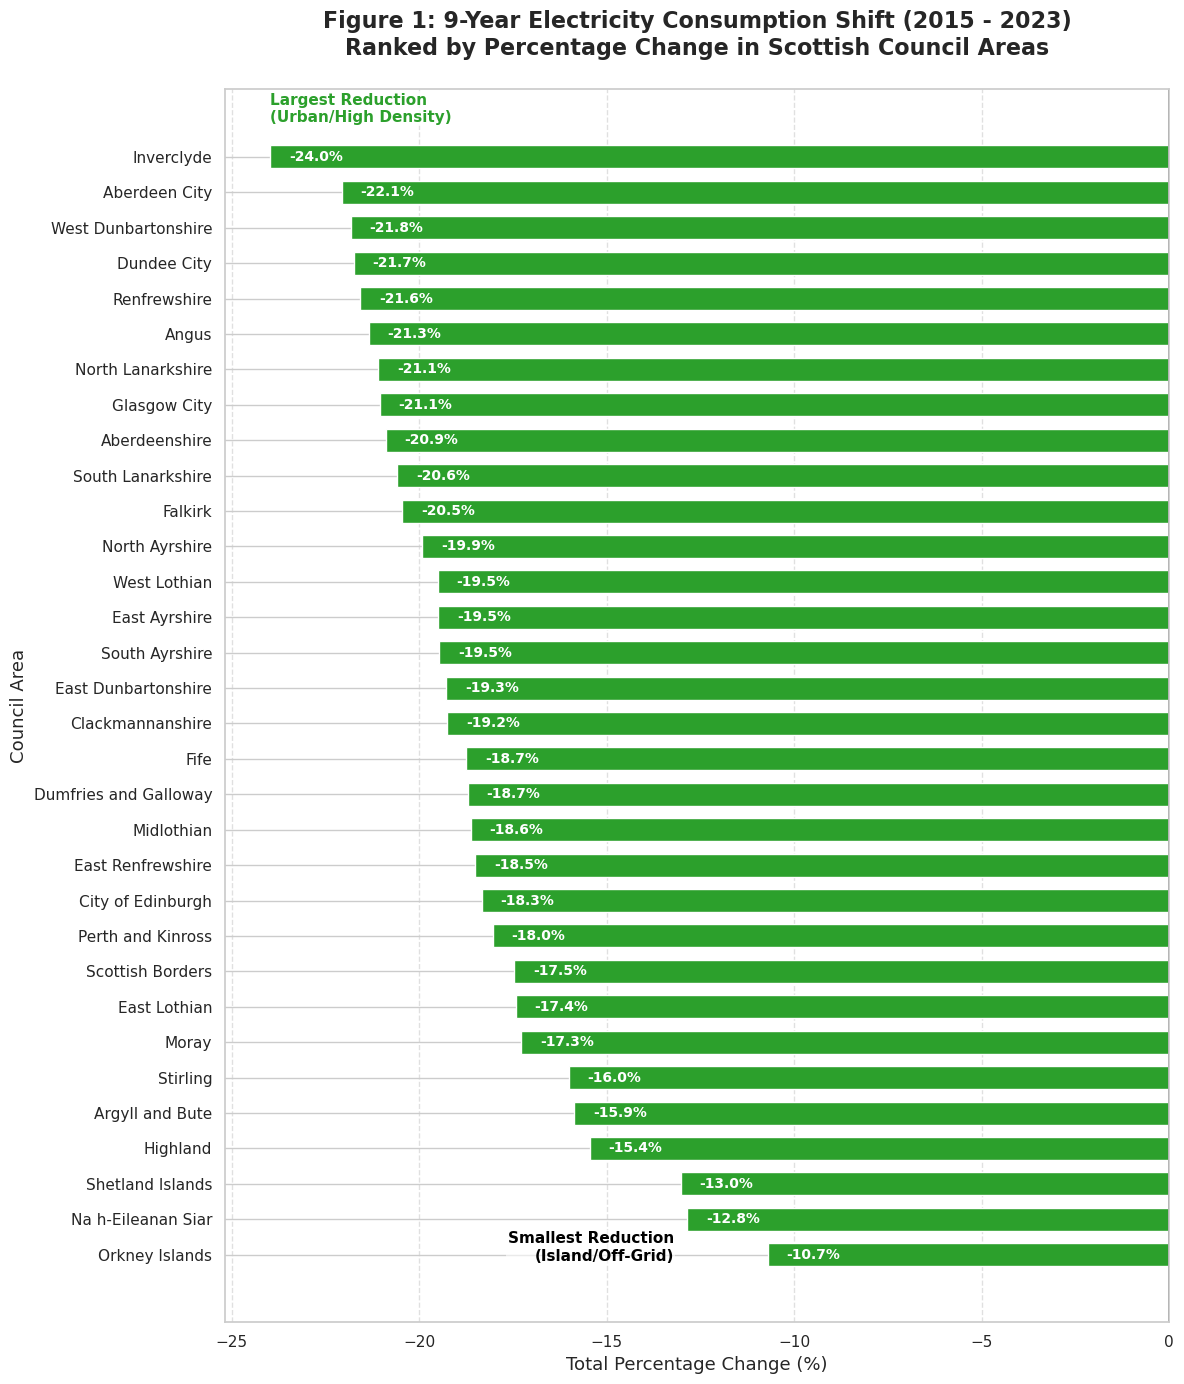

The average percentage change across all council areas is -18.76%


In [45]:
# Codebox 1

#Set plotting style to be clean and professional
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

def plot_overall_trend_ranking():
    #Locate and Load Data
    filename = "Scotland_Council_Change_Analysis.csv"
    df = pd.read_csv(filename, index_col=0)
    
    #Prepare Data for Plotting
    # Sort the data: Largest reduction (most negative change) at the TOP
    df_sorted = df.sort_values(by='Change_Pct', ascending=True)
    
    # Create a color list based on the values
    # Green for reduction (negative change), Red for increase (positive change)
    colors = ['#2ca02c' if x < 0 else '#d62728' for x in df_sorted['Change_Pct']]
    
    #Create the Horizontal Bar Chart
    # Set figure height to fit all 32 council areas comfortably
    plt.figure(figsize=(12, 14))
    
    # Create the bars
    bars = plt.barh(df_sorted.index, df_sorted['Change_Pct'], color=colors, height=0.65)
    
    #Add Styling and Decorations
    plt.axvline(0, color='black', linewidth=1.2, linestyle='-') # Center line at 0%
    
    # Title and Labels using neutral terminology
    plt.title('Figure 1: 9-Year Electricity Consumption Shift (2015 - 2023)\nRanked by Percentage Change in Scottish Council Areas', 
              fontsize=16, fontweight='bold', pad=25)
    plt.xlabel('Total Percentage Change (%)', fontsize=13)
    plt.ylabel('Council Area', fontsize=13)
    
    # Invert Y-axis so the area with Rank 1 is at the TOP
    plt.gca().invert_yaxis()
    
    # Add Gridlines (Vertical only) for easier reading
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    #Add Value Labels to Each Bar
    # Place percentage values inside the bars for better readability
    for bar in bars:
        width = bar.get_width() # width is negative, e.g., -24.0
        
        # Position: Inside the bar (width + offset towards 0)
        label_x_pos = width + 0.5 
        
        plt.text(label_x_pos, 
                 bar.get_y() + bar.get_height()/2, 
                 f'{width:.1f}%', 
                 va='center', 
                 ha='left',     # Left align to ensure text extends inside the bar
                 fontsize=10, 
                 fontweight='bold',
                 color='white') # White font for contrast against green bars

    
    #Highlight the largest reduction (Top of the list)
    top_saver_idx = 0
    top_val = df_sorted['Change_Pct'].iloc[top_saver_idx]
    
    plt.text(top_val, -0.9, 
             "Largest Reduction\n(Urban/High Density)", 
             ha='left', va='bottom', 
             fontweight='bold', color='#2ca02c', fontsize=11,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

    #Highlight the smallest reduction (Bottom of the list)
    worst_performer_idx = len(df_sorted) - 1
    worst_val = df_sorted['Change_Pct'].iloc[worst_performer_idx]
    
    # Position text slightly to the left to avoid overlapping with the bar end
    plt.text(worst_val - 2.5, worst_performer_idx - 0.2, 
             "Smallest Reduction\n(Island/Off-Grid)", 
             ha='right', va='center', 
             fontweight='bold', color='black', fontsize=11,
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    #Save and Show
    plt.tight_layout()
    output_path = "Overall_Ranking.png"
    plt.savefig(output_path, dpi=300)
    print(f"Chart saved successfully to: {output_path}")
    plt.show()

    # Print the mean percentage change
    mean_change = df['Change_Pct'].mean()
    print(f"The average percentage change across all council areas is {mean_change:.2f}%")

if __name__ == "__main__":
    plot_overall_trend_ranking()


Figure 1 shows the percentage change in electricty consumption for all Scottish Council Areas, comparing 2015 with 2023. All areas experienced a decrease in consumption, with Inverclyde showing the largest reduction at 24% and the Orkney Islands the lowest at 10.7%. Overall, more rural areas including islands and off-grid locations tended to have the smallest reductions, while more urban and densely populated areas, such as major cities, experienced the largest reductions.

There are many possible reasons for this stark difference between urban and rural regions. One key factor is the greater upkeep of energy efficiency measures and newer infrastructure in urban areas. Rural areas tend to have older housing stock and less access to energy saving initiatives, therefore leading to smaller reductions. On average Scottish Council Areas reduced electricity consumption by 18.76%, highlighting a general trend toward lower energy use in the country.

# Housing Across the years

Steps:

1. Look at top 5 council areas housing in 2011 and 2022 and look at proportion of housing in the top 5 council areas
2. Plot bar charts for both years for all 5 council areas

In [14]:
#1. store info on top 5 council areas

council_top_5 = pd.read_csv('council area with elec consumption/Selected_5_Councils_DataZone_Level.csv')
council_top_5 = council_top_5.drop(['Num_meters',
       'Mean_Consumption_kWh'], axis=1)
postcode_lookup = pd.read_csv('council area with elec consumption/Scottish_Postcode_Lookup_2025_1.csv')
#postcode_lookup = postcode_lookup[['Postcode','DataZone']]

#2022 data for house hold - plot bar chart - x_axis is all council areas, y_axis is percentage of different types of households composing that council area

data_2011 = pd.read_csv('housing_data_2011.csv')
data_2011.columns
type1 = ['DataZone',  'Unshared dwelling: Total','Shared dwelling']
type2 = ['DataZone','Unshared dwelling: Whole house or bungalow','Unshared dwelling: Flat, maisonette or apartment',
         'Unshared dwelling: Caravan or other mobile or temporary structure','Shared dwelling']
top_5 = ['City of Edinburgh', 'Glasgow City', 'Highland', 'Orkney Islands',
       'West Lothian']

#Want to add council area name to house data
#data_2011.columns - 'Datazone 2011'
#council_top_5.columns - 'DataZone'

data_2011 = data_2011.rename(columns={'Datazone 2011': 'DataZone'})

data_2011_updated = data_2011.merge(
    council_top_5[['DataZone', 'Council_Area']],
    on='DataZone',
    how='left'   
)

#print(data_2011_updated.head())
#print(data_2011_updated.isna().sum())  # check if any datazones didn’t match

#data_2011_updated = data_2011_updated[data_2011_updated['Council_Area'].isin(top_5)]
print(data_2011_updated['Council_Area'])
barchart_df = data_2011_updated.copy()

barchart_df['Whole House'] = barchart_df.groupby('Council_Area')['Unshared dwelling: Whole house or bungalow'].transform('sum')
barchart_df['Flats'] = barchart_df.groupby('Council_Area')['Unshared dwelling: Flat, maisonette or apartment'].transform('sum')
barchart_df['Caravan'] = barchart_df.groupby('Council_Area')['Unshared dwelling: Caravan or other mobile or temporary structure'].transform('sum')
barchart_df['Shared'] = barchart_df.groupby('Council_Area')['Shared dwelling'].transform('sum')

#barchart_df = barchart_df.drop_duplicates('Council_Area')
#len(barchart_df)

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
6971    NaN
6972    NaN
6973    NaN
6974    NaN
6975    NaN
Name: Council_Area, Length: 6976, dtype: object


In [ ]:
#Data Set upelectricity_data = pd.read_csv('cleaning data with code/clean_data/electricity_scotland_2023.csv')
postcode_data = pd.read_csv('council area with elec consumption/Scottish_Postcode_Lookup_2025_1.csv')
postcode_data = postcode_data[['Postcode','DataZone2011Code','CouncilArea2019Code']]
house_data = pd.read_csv('housing_data.csv')
columns_needed = ['Data Zone','Whole house or bungalow: Total','Flat, maisonette or apartment: Total','Caravan or other mobile or temporary structure']
house_data = house_data[columns_needed]


#Adding datazone info for 
electricity_data = electricity_data.merge(postcode_data[['CouncilArea2019Code', 'Postcode']],left_on='Council Area',right_on='CouncilArea2019Code',how='left')
#electricity_data= electricity_data.drop(['Num_meters','Mean_cons_kwh','Median_cons_kwh'],axis=1)
#electricity_data['Consumption for datazone'] = electricity_data.groupby('DataZone2011Code')['Total_cons_kwh'].transform('sum')
electricity_data.head()

In [16]:
electricity_data = pd.read_csv('cleaning data with code/clean_data/electricity_scotland_2023.csv')
postcode_data = pd.read_csv('council area with elec consumption/Scottish_Postcode_Lookup_2025_1.csv')
postcode_data = postcode_data[['Postcode','DataZone2011Code','CouncilArea2019Code']]
house_data = pd.read_csv('housing_data.csv')
columns_needed = ['Data Zone','Whole house or bungalow: Total','Flat, maisonette or apartment: Total','Caravan or other mobile or temporary structure']
house_data = house_data[columns_needed]

# Standardise formatting first
electricity_data['Postcode'] = electricity_data['Postcode'].str.upper().str.strip().str.replace(" ", "")
postcode_data['Postcode'] = postcode_data['Postcode'].str.upper().str.strip().str.replace(" ", "")

# Merge council area code onto electricity dataset using postcode as key
council_area_electricity = electricity_data.merge(
    postcode_data[['Postcode', 'CouncilArea2019Code']],
    on='Postcode',
    how='left'  # keep all rows from electricity_data even if postcode lookup is missing
)
print(electricity_data['Postcode'].nunique(),postcode_data['Postcode'].nunique())

# Inspect result
#print(council_area_electricity.head())
#print(council_area_electricity.isna().sum())
postcode_data.isna().sum()
print(len(electricity_data),len(council_area_electricity))

# Standardise formatting first
electricity_data['Postcode'] = electricity_data['Postcode'].str.upper().str.strip().str.replace(" ", "")
postcode_data['Postcode'] = postcode_data['Postcode'].str.upper().str.strip().str.replace(" ", "")

# Identify postcodes in electricity dataset that do not exist in postcode lookup
missing_postcodes_initial = electricity_data[~electricity_data['Postcode'].isin(postcode_data['Postcode'])]

print("Number of missing postcodes:", missing_postcodes_initial.shape[0])
missing_postcodes_initial.head()


121238 228867
121238 121238
Number of missing postcodes: 450


,Outcode,Postcode,Num_meters,Total_cons_kwh,Mean_cons_kwh,Median_cons_kwh
14897,DD3,DD36PF,16,56089.600,3505.600000,3505.60
20757,DG16,DG165JA,6,20380.900,3396.816667,3452.45
118343,TD12,TD124QB,21,77567.000,3693.666667,2733.40
118344,TD12,TD124QD,12,73178.224,6098.185333,2411.50
118345,TD12,TD124QF,5,16903.600,3380.720000,2941.20


In [ ]:



electricity_data = electricity_data.merge(postcode_data[['DataZone2011Code', 'Postcode']],left_on='Postcode',right_on='Postcode',how='left')
electricity_data= electricity_data.drop(['Num_meters','Mean_cons_kwh','Median_cons_kwh'],axis=1)
electricity_data['Consumption for datazone'] = electricity_data.groupby('DataZone2011Code')['Total_cons_kwh'].transform('sum')


data_zone_electricity = electricity_data.drop_duplicates('DataZone2011Code')
data_zone_electricity = data_zone_electricity.drop(['Outcode','Postcode','Total_cons_kwh'],axis=1)


house_data_electricity = house_data.merge(data_zone_electricity[['DataZone2011Code', 'Consumption for datazone']],left_on='Data Zone',right_on='DataZone2011Code',  how='left')

house_data_electricity['Whole house or bungalow: Total'] = (
    house_data_electricity['Whole house or bungalow: Total']
    .str.rstrip('%')          # remove % at the end
    .astype(float)            # convert to float
)

house_data_electricity['Flat, maisonette or apartment: Total'] = (
    house_data_electricity['Flat, maisonette or apartment: Total']
    .str.rstrip('%')          # remove % at the end
    .astype(float)            # convert to float
)

house_data_electricity['Caravan or other mobile or temporary structure'] = (
    house_data_electricity['Caravan or other mobile or temporary structure']
    .str.rstrip('%')          # remove % at the end
    .astype(float)            # convert to float
)



In [ ]:
house_data_electricity['Whole House'] = (house_data_electricity['Whole house or bungalow: Total'] >= 80).astype(int)
house_data_electricity['Flats'] = (house_data_electricity['Flat, maisonette or apartment: Total'] >= 80).astype(int)
house_data_electricity['Other'] = (house_data_electricity['Caravan or other mobile or temporary structure'] >= 90).astype(int)


flat_electricity = house_data_electricity[house_data_electricity['Flats']==1]
whole_house_electricity = house_data_electricity[house_data_electricity['Whole House']==1]

#print(flat_electricity.describe())
#print(whole_house_electricity.describe())

#Boxplot this info



import pandas as pd
import matplotlib.pyplot as plt

# Example: Assume df has numeric columns like ['Consumption_2020', 'Consumption_2023']
flat_electricity.boxplot(column=['Consumption for datazone'])


plt.title("Electricity Consumption Distribution")
plt.ylabel("kWh per household")
plt.show()

whole_house_electricity.boxplot(column= ['Consumption for datazone'])
plt.title("Electricity Consumption Distribution")
plt.ylabel("kWh per household")
plt.show()